## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [ ]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load(disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

# row/column display limit
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [ ]:
# Opening JSON file 
with open('complaints.json','r') as f_read:
    data = json.loads(f_read.read())
# returns JSON object as  
# a dictionary 
#data = json.load(data)
df=pd.json_normalize(data)
df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and was told by the agent who did the upgrade my anniversary date would not change. It turned the agent was giving me the wrong information in order to upgrade the account. XXXX changed my anniversary date from XX/XX/XXXX to XX/XX/XXXX without my consent! XXXX has the recording of the agent who was misled me.,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


## Data preparation

Inspect the dataframe to understand the given data:



In [ ]:
## We shall print the number of rows and columns in the dataframe

print('The number of rows and columns in the dataframe..',df.shape[0],'and',df.shape[1],'respectively')

##To understand different data types in the data print the int,object columns

print(df.dtypes)


The number of rows and columns in the dataframe.. 78313 and 22 respectively
_index                                object
_type                                 object
_id                                   object
_score                               float64
_source.tags                          object
_source.zip_code                      object
_source.complaint_id                  object
_source.issue                         object
_source.date_received                 object
_source.state                         object
_source.consumer_disputed             object
_source.product                       object
_source.company_response              object
_source.company                       object
_source.submitted_via                 object
_source.date_sent_to_company          object
_source.company_public_response       object
_source.sub_product                   object
_source.timely                        object
_source.complaint_what_happened       object
_source.sub_issue       

In [ ]:
#print the column names
print(df.columns)



Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')


In [ ]:
#Assign new column names
#Using regex we shall remove the ^ and source. from the column names (https://www.dataquest.io/blog/regex-cheatsheet/)
#Removing '_' from columns
df.columns=[re.sub('^_','',col) for col in df.columns]#^ Matches the expression to its right at the start of a string. It matches every such instance before each \n in the string.
#Removing 'source.' from columns
df.columns=[re.sub(r"^\bsource\b\.", "", col)  for col in df.columns] #b Matches the boundary (or empty string) at the start and end of a word, that is, between \w and \W.
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [ ]:
#Assign nan in place of blanks in the complaints column
df=df.rename(columns={'complaint_what_happened':'complaint_description'})
df.isnull().sum()

index                            0
type                             0
id                               0
score                            0
tags                         67413
zip_code                      6757
complaint_id                     0
issue                            0
date_received                    0
state                         1991
consumer_disputed                0
product                          0
company_response                 0
company                          0
submitted_via                    0
date_sent_to_company             0
company_public_response      78309
sub_product                  10571
timely                           0
complaint_description            0
sub_issue                    46297
consumer_consent_provided     1008
dtype: int64

In [ ]:
#Remove all rows where complaints column is nan
# replace field that's entirely space (or empty) with NaN
df['complaint_description']=df['complaint_description'].replace(r'^\s*$', np.nan, regex=True)
df['complaint_description'].head()

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           NaN
1    Good morning my name is XXXX XXXX and I appreciate it if you could help me put a stop to Chase Bank cardmember services. \nIn 2018 I wrote to Chase asking for debt verification and what they sent me a statement which is not acceptable. I am asking the bank to validate the debt. Instead I been receiving mail every month from them attempting to collect a debt. \nI have a right to know this information as a consumer. \n\nChase account # XXXX XXXX XXXX XXXX Thanks in advance for your help.
2       

In [ ]:
##Removing Nan from complaint_description

df.dropna(subset=['complaint_description'],inplace=True)
df.shape

(21072, 22)

In [ ]:
##Inspect the complaint_description columns
df['complaint_description'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [ ]:
# Write your function here to clean the text and remove all the unnecessary elements.
#Make the test lower
def clean_text(text):
    text=text.lower()
#Remove text in square brackets using regex
#a='Welcome to India(nation with diverse culture)[decorated with food cusines]'
#a = re.sub(r"[\([{})\]]", ' ', a)
#print(a)
    text=re.sub(r"[\([{})\]]", '', text)
#Remove punctuation
    text= re.sub(r'[^\w\s]', '', text)
#Remove words containing numbers
    text= re.sub(r'[0-9]', '', text)
    return text

In [ ]:
df['complaint_description']=df['complaint_description'].apply(lambda x:clean_text(x))
df['complaint_description'].head()

1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      good morning my n

In [ ]:
#Write your function to Lemmatize the texts
def text_lematized(text):     
    lemma_list = []
    # Extract lemmas of given text and add to the list 'sent'
    lemma_process = nlp(text)
    for word in lemma_process:
        lemma_list.append(word.lemma_)
    # return string converted form of the list of lemmas
    return " ".join(lemma_list)



In [ ]:
df['lematized_complaint']=df['complaint_description'].apply(lambda x:text_lematized(x))

In [ ]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean=df[['complaint_description','lematized_complaint']]

In [ ]:
df_clean.head()

,complaint_description,lematized_complaint
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticket i come across an offer for to be apply towards the ticket if i apply for a reward card i put in -PRON- information for the offer and within less than a minute be notify via the screen that a decision could not be make i immediately contact xxxx and be refer to chase bank i then immediately contact chase bank within no more than minute of get the notifi

We verified that the nltk's spacy pos tagging does good job but certain nuances are captured well by text blob and we found this through experimentation

In [ ]:
##Using text blobs
from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
#Write your function to extract the POS tags
#Let us keep only the Noun tag and we found that other tags are not greatly useful for topic inspection


def pos_tagging(text):
    #text=nlp(text)
    text_pos=TextBlob(text)
    return ' '.join([i[0] for i in text_pos.tags if i[1]=='NN'])
    




In [ ]:
df_clean['pos_tagged_complaints']=df_clean['lematized_complaint'].apply(lambda x:pos_tagging(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,complaint_description,lematized_complaint,pos_tagged_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning -PRON- name -PRON- stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance -PRON- help
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card xxxx agent upgrade date agent information order account change date xxxxxxxx consent recording agent
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx 

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




Text(0, 0.5, 'No. of Complaints')

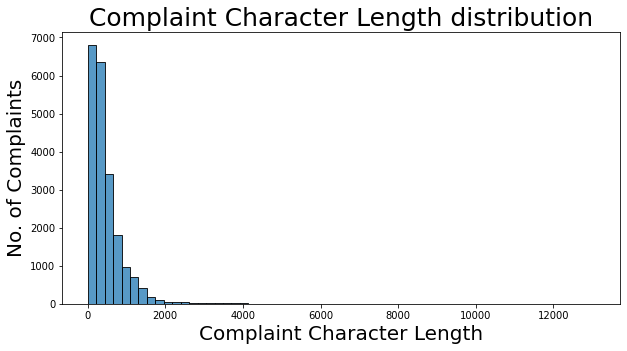

In [ ]:
# Write your code here to visualise the data according to the 'Complaint' character length

complaint_length=[len(x) for x in df_clean['pos_tagged_complaints']]
plt.figure(figsize=[10,5])
sns.histplot(data = complaint_length,bins=60)
plt.title('Complaint Character Length distribution', fontsize=25)
plt.xlabel('Complaint Character Length',size=20)
plt.ylabel('No. of Complaints',size=20)

Small note here is most of the complaint lengths issued by the client contain no more than 3000
words in general and there are very few complaints with more words

#### Find the top 40 words by frequency among all the articles after processing the text.

In [ ]:
from wordcloud import WordCloud, STOPWORDS

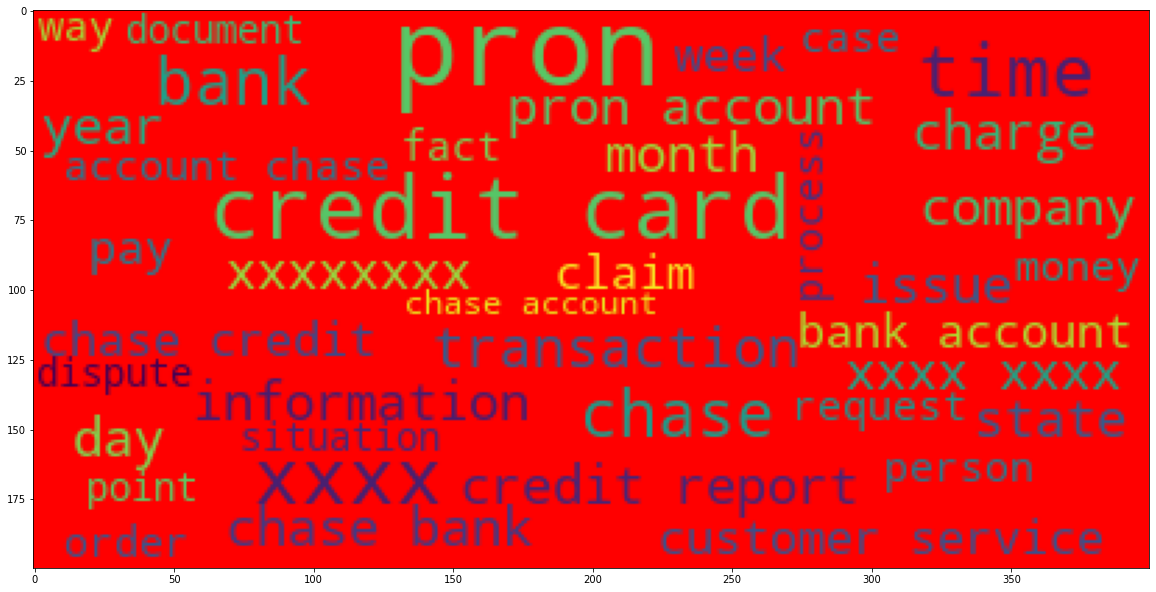

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
freq_words = ''
stopwords = set(STOPWORDS)
 
# iterate through the csv file
for val in df_clean.pos_tagged_complaints:
     
        #Split the val and make it lower
        tokens=str(val).split()
     
    # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        freq_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(max_font_size=40,max_words=40,
                background_color ='red',
                stopwords = stopwords,
                random_state=42).generate(freq_words)
 
#plot the WordCloud image                      
plt.figure(figsize = (20,15), facecolor = None)
plt.imshow(wordcloud)
plt.show()


In [ ]:
#Removing -PRON- from the text corpus
#We already removed the PRON so no need of the below code
df_clean['pos_tagged_complaints'] = df_clean['pos_tagged_complaints'].str.replace('-PRON-', '')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

Writing a generic function which accepts n-grams and plot as the parameters

In [ ]:
from nltk.corpus import stopwords
from nltk import ngrams
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
##Writing ngram function
def top_n_grams(text,freq, n=None):
    vec = CountVectorizer(ngram_range=(n,n), stop_words='english').fit(text)
    bag_of_words = vec.transform(text)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:freq]

  
  

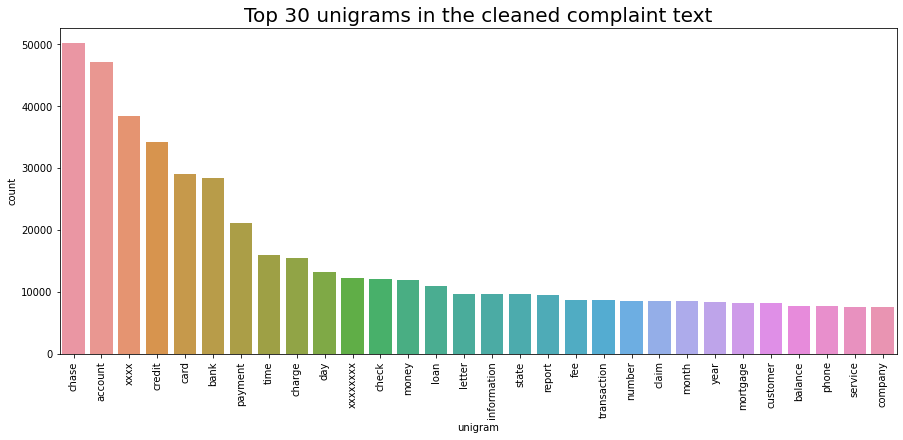

In [ ]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
top_common_words = top_n_grams(df_clean['pos_tagged_complaints'],30,1)
unigram_freq = pd.DataFrame(top_common_words, columns = ['unigram' , 'count'])
plt.figure(figsize=(15,6))
sns.barplot(x='unigram', y='count', data=unigram_freq)
plt.xticks(rotation=90)
plt.title("Top 30 unigrams in the cleaned complaint text", fontsize=20)
plt.show()


In [ ]:
#Print the top 10 words in the unigram frequency
unigram_freq[:10]

,unigram,count
0,chase,50130
1,account,47185
2,xxxx,38490
3,credit,34156
4,card,29084
5,bank,28400
6,payment,21171
7,time,16035
8,charge,15549
9,day,13243


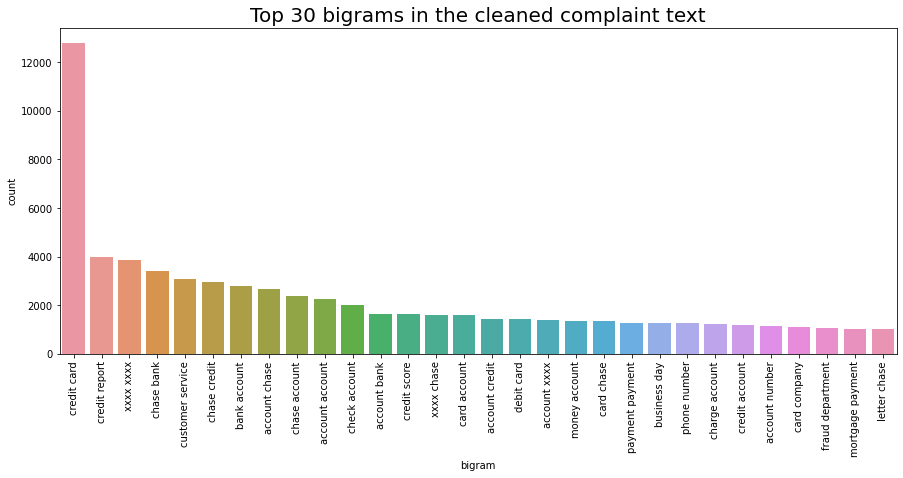

In [ ]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
top_common_words = top_n_grams(df_clean['pos_tagged_complaints'],30,2)
bigram_freq = pd.DataFrame(top_common_words, columns = ['bigram' , 'count'])
plt.figure(figsize=(15,6))
sns.barplot(x='bigram', y='count', data=bigram_freq)
plt.xticks(rotation=90)
plt.title("Top 30 bigrams in the cleaned complaint text", fontsize=20)
plt.show()


In [ ]:
#Print the top 10 words in the bigram frequency
bigram_freq[:10]

,bigram,count
0,credit card,12778
1,credit report,3979
2,xxxx xxxx,3851
3,chase bank,3426
4,customer service,3078
5,chase credit,2947
6,bank account,2770
7,account chase,2680
8,chase account,2383
9,account account,2262


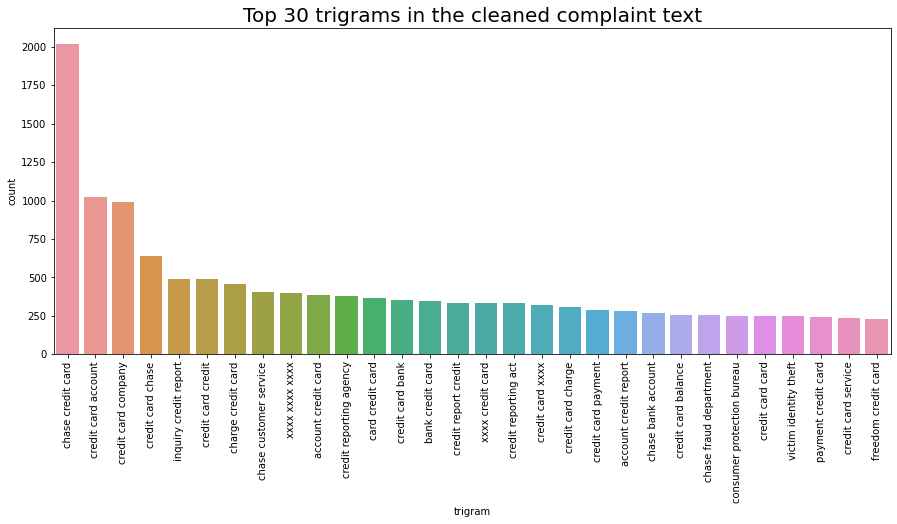

In [ ]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
top_common_words = top_n_grams(df_clean['pos_tagged_complaints'],30,3)
trigram_freq = pd.DataFrame(top_common_words, columns = ['trigram' , 'count'])
plt.figure(figsize=(15,6))
sns.barplot(x='trigram', y='count', data=trigram_freq)
plt.xticks(rotation=90)
plt.title("Top 30 trigrams in the cleaned complaint text", fontsize=20)
plt.show()


In [ ]:
#Print the top 10 words in the trigram frequency
trigram_freq[:10]

,trigram,count
0,chase credit card,2021
1,credit card account,1022
2,credit card company,991
3,credit card chase,637
4,inquiry credit report,489
5,credit card credit,487
6,charge credit card,457
7,chase customer service,404
8,xxxx xxxx xxxx,401
9,account credit card,384


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [ ]:
df_clean['pos_tagged_complaints'] = df_clean['pos_tagged_complaints'].str.replace('xxxx','')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
#All masked texts has been removed
df_clean.head()

,complaint_description,lematized_complaint,pos_tagged_complaints
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxxx xxxx ticke

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [ ]:
#Write your code here to initialise the TfidfVectorizer 

vect = TfidfVectorizer(max_df=0.95,min_df=2,stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [ ]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
X = vect.fit_transform(df_clean.pos_tagged_complaints)

pd.DataFrame(X.toarray(), columns=vect.get_feature_names()).head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



aa  aarp  aback  abandon  abandonment  abatement  abbreviation  abd  abet  \
0  0.0   0.0    0.0      0.0          0.0        0.0           0.0  0.0   0.0   
1  0.0   0.0    0.0      0.0          0.0        0.0           0.0  0.0   0.0   
2  0.0   0.0    0.0      0.0          0.0        0.0           0.0  0.0   0.0   
3  0.0   0.0    0.0      0.0          0.0        0.0           0.0  0.0   0.0   
4  0.0   0.0    0.0      0.0          0.0        0.0           0.0  0.0   0.0   

   abide  ability  abovementione  abovename  abovereference  abreast  abscond  \
0    0.0      0.0            0.0        0.0             0.0      0.0      0.0   
1    0.0      0.0            0.0        0.0             0.0      0.0      0.0   
2    0.0      0.0            0.0        0.0             0.0      0.0      0.0   
3    0.0      0.0            0.0        0.0             0.0      0.0      0.0   
4    0.0      0.0            0.0        0.0             0.0      0.0      0.0   

   absence  absent  absolute  absolve  absorb  absurd  absurdity  abundance  \
0      0.0     0.0       0.0      0.0     0.0     0.0        0.0        0.0   
1      0.0     0.0       0.0      0.0     0.0     0.0        0.0        0.0   
2      0.0     0.0       0.0      0.0     0.0     0.0        0.0        0.0   
3      0.0     0.0       0.0      0.0     0.0     0.0        0.0        0.0   
4      0.0     0.0       0.0      0.0     0.0     0.0        0.0        0.0   

   abuse  abuser  abusive   ac  acc  acccount  acceleration  accent  accept  \
0    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
1    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
2    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
3    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   
4    0.0     0.0      0.0  0.0  0.0       0.0           0.0     0.0     0.0   

   acceptance  access  accessibility  accessory  accident  accidental  acco  \
0         0.0     0.0            0.0        0.0       0.0         0.0   0.0   
1         0.0     0.0            0.0        0.0       0.0         0.0   0.0   
2         0.0     0.0            0.0        0.0       0.0         0.0   0.0   
3         0.0     0.0            0.0        0.0       0.0         0.0   0.0   
4         0.0     0.0            0.0        0.0       0.0         0.0   0.0   

   accommodate  accommodation  accomodation  accompany  accomplice  \
0          0.0            0.0           0.0        0.0         0.0   
1          0.0            0.0           0.0        0.0         0.0   
2          0.0            0.0           0.0        0.0         0.0   
3          0.0            0.0           0.0        0.0         0.0   
4          0.0            0.0           0.0        0.0         0.0   

   accomplish  accont  accord  accordance  accou  accouint  accoun  accound  \
0         0.0     0.0     0.0         0.0    0.0       0.0     0.0      0.0   
1         0.0     0.0     0.0         0.0    0.0       0.0     0.0      0.0   
2         0.0     0.0     0.0         0.0    0.0       0.0     0.0      0.0   
3         0.0     0.0     0.0         0.0    0.0       0.0     0.0      0.0   
4         0.0     0.0     0.0         0.0    0.0       0.0     0.0      0.0   

    account  accountability  accountant  accountbalance  accountchase  \
0  0.078393             0.0         0.0             0.0           0.0   
1  0.083788             0.0         0.0             0.0           0.0   
2  0.000000             0.0         0.0             0.0           0.0   
3  0.117592             0.0         0.0             0.0           0.0   
4  0.128342             0.0         0.0             0.0           0.0   

   accountholder  accounti  accounting  accountit  accountlevel  accounton  \
0            0.0       0.0         0.0        0.0           0.0        0.0   
1            0.0       0.0         0.0        0.0           0.0        0.0   
2            0.0       0.0         0

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [ ]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [ ]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5

#keep the random_state =40
nmf_model = NMF(n_components=num_topics,random_state=40)

In [ ]:
nmf_model.fit(X)
len(vect.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



7422

Using nmf_model.components_ we get the index and the topic weights, we shall sort the topic
weights based on argmax() and get the appropriate words from the tfidf vector using the 
get_feature_names option 

In [ ]:
#Print the Top15 words for each of the topics

topic_dict={}
freq_word={}
for i,j in enumerate(nmf_model.components_):
    topic_dict[i]=j.argsort()[-15:]
#print(max_words)
for index,word_vect in topic_dict.items():
    freq_word[index]=[vect.get_feature_names()[value] for value in topic_dict[index]]
Top_15=pd.DataFrame.from_dict(freq_word)
Top_15=Top_15.rename(columns={0:'Topic 0',1:'Topic 1',2:'Topic 2',3:'Topic 3',4:'Topic 4'})
Top_15

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,customer,balance,car,company,sale
1,transfer,year,year,statement,foreclosure
2,claim,letter,chase,time,house
3,transaction,application,account,refund,bank
4,business,debt,credit,service,document
5,number,information,date,fraud,time
6,day,limit,time,claim,rate
7,branch,company,auto,purchase,letter
8,deposit,score,pay,merchant,year
9,fund,account,day,dispute,property


In [ ]:
#[vect.get_feature_names()[value] for value in max_words.values()]
#for i in max_words.values():
    #print(i)

In [ ]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
colnames = ["Topic" + str(i) for i in range(5)]
docnames = ["Doc" + str(i) for i in range(df_clean.shape[0])]
best_topic=nmf_model.transform(X)
#best_topic.shape
#There are totally 5 topics assigned to each description, we take the largest of these
best_topic_df=pd.DataFrame(np.round(best_topic, 2), columns=colnames, index=docnames)
#best_topic_df['dominant_topic'] = best_topic_df
dominant_topic=np.argmax(best_topic_df.values, axis=1)

In [ ]:
best_topic_df.head()

,Topic0,Topic1,Topic2,Topic3,Topic4
Doc0,0.02,0.01,0.01,0.01,0.02
Doc1,0.01,0.01,0.00,0.01,0.01
Doc2,0.00,0.05,0.00,0.00,0.00
Doc3,0.02,0.06,0.00,0.01,0.02
Doc4,0.08,0.00,0.00,0.01,0.01


In [ ]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = dominant_topic

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint_description,lematized_complaint,pos_tagged_complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,0
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,1
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxx

In [ ]:
#Print the first 5 Complaint for each of the Topics
df_clean_1=df_clean.groupby('Topic').head(5)
df_clean_1.sort_values('Topic')

,complaint_description,lematized_complaint,pos_tagged_complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,0
14,my grand son give me check for i deposit it into my chase account after fund clear my chase bank closed my account never paid me my money they said they need to speek with my grand son check was clear money was taking by my chase bank refuse to pay me my money my grand son called chase times they told him i should call not him to verify the check owner he is out the country most the time date happen xxxx check number xxxx claim number is xxxx with chase,-PRON- grand son give -PRON- check for i deposit -PRON- into -PRON- chase account after fund clear -PRON- chase bank close -PRON- account never pay -PRON- -PRON- money -PRON- say -PRON- need to speek with -PRON- grand son check be clear money be take by -PRON- chase bank refuse to pay -PRON- -PRON- money -PRON- grand son call chase time -PRON- tell -PRON- i should call not -PRON- to verify the check owner -PRON- be out the country most the time date happen xxxx check number xxxx claim number be xxxx with chase,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date number claim number chase,0
17,with out notice jp morgan chase restricted my account by my debit card tuesday xxxx on thursday xxxx i went into a branch after being advised by a customer service representative that my account would actually be closed i went into the branch to see how i can remove the funds that are in there currently in as well as if my direct deposit from my place of employment would be returned the bank associate and the customer service representative assured me that the funds would post but they may take an additional business day that saturday i attempted to go inside of a branch yet again to retrieve my funds that actually did post on friday xxxx upon looking at my account i realize that the funds have been reversed and no longer were present on my current statement ive been called and i was told that it may take two bus

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [ ]:
Top_15

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
0,customer,balance,car,company,sale
1,transfer,year,year,statement,foreclosure
2,claim,letter,chase,time,house
3,transaction,application,account,refund,bank
4,business,debt,credit,service,document
5,number,information,date,fraud,time
6,day,limit,time,claim,rate
7,branch,company,auto,purchase,letter
8,deposit,score,pay,merchant,year
9,fund,account,day,dispute,property


In [ ]:
#Create the dictionary of Topic names and Topics

Topic_names = {0:'Bank Account services',1:'Credit card or prepaid card'
              ,2:'Others',3:'Theft/Dispute Reporting',4:'Mortgage/Loan'}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint_description,lematized_complaint,pos_tagged_complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,Bank Account services
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,Bank Account services
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,Credit card or prepaid card
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [ ]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 'Bank Account services':0,'Credit card or prepaid card':1,'Mortgage/Loan':4,
              'Theft/Dispute Reporting':3,'Others':2}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
df_clean.head()

,complaint_description,lematized_complaint,pos_tagged_complaints,Topic
1,good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account xxxx xxxx xxxx xxxx thanks in advance for your help,good morning -PRON- name be xxxx xxxx and i appreciate -PRON- if -PRON- could help -PRON- put a stop to chase bank cardmember service \n in i write to chase ask for debt verification and what -PRON- send -PRON- a statement which be not acceptable i be ask the bank to validate the debt instead i be receive mail every month from -PRON- attempt to collect a debt \n i have a right to know this information as a consumer \n\n chase account xxxx xxxx xxxx xxxx thank in advance for -PRON- help,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i upgraded my xxxx xxxx card in xxxx and was told by the agent who did the upgrade my anniversary date would not change it turned the agent was giving me the wrong information in order to upgrade the account xxxx changed my anniversary date from xxxxxxxx to xxxxxxxx without my consent xxxx has the recording of the agent who was misled me,i upgrade -PRON- xxxx xxxx card in xxxx and be tell by the agent who do the upgrade -PRON- anniversary date would not change -PRON- turn the agent be give -PRON- the wrong information in order to upgrade the account xxxx change -PRON- anniversary date from xxxxxxxx to xxxxxxxx without -PRON- consent xxxx have the recording of the agent who be mislead -PRON-,i card agent upgrade date agent information order account change date consent recording agent,0
10,chase card was reported on xxxx however fraudulent application have been submitted my identity without my consent to fraudulently obtain services do not extend credit without verifying the identity of the applicant,chase card be report on xxxx however fraudulent application have be submit -PRON- identity without -PRON- consent to fraudulently obtain service do not extend credit without verify the identity of the applicant,card application identity consent service credit identity applicant,1
11,on xxxx while trying to book a xxxx xxxx ticket i came across an offer for to be applied towards the ticket if i applied for a rewards card i put in my information for the offer and within less than a minute was notified via the screen that a decision could not be made i immediately contacted xxxx and was referred to chase bank i then immediately contacted chase bank within no more than minutes of getting the notification on the screen and i was told by the chase representative i spoke with that my application was denied but she could not state why i asked for more information about the xxxx offer and she explained that even if i had been approved the credit offer only gets applied after the first account statement and could not be used to purchase the ticket i then explicitly told her i was glad i got denied and i was absolutely no longer interested in the account i asked that the application be withdrawn and the representative obliged this all happened no later than mins after putting in the application on xxxx notwithstanding my explicit request not to proceed with the application and contrary to what i was told by the chase representative chase did in fact go ahead to open a credit account in my name on xxxx this is now being reported in my credit report and chase has refused to correct this information on my credit report even though they went ahead to process an application which i did not consent to and out of their error,on xxxx while try to book a xxx

In [ ]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data=df_clean[["pos_tagged_complaints","Topic"]]
training_data['pos_tagged_complaints']=training_data['pos_tagged_complaints'].astype('U')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
training_data.head()

,pos_tagged_complaints,Topic
1,morning name stop bank cardmember service ask debt verification statement i bank debt mail month attempt debt i right information consumer chase account thank advance help,0
2,i card agent upgrade date agent information order account change date consent recording agent,0
10,card application identity consent service credit identity applicant,1
11,try book ticket i offer ticket card i information offer minute screen decision bank i chase bank minute notification screen i chase representative i application state i ask information offer credit offer account statement use ticket i account i application representative oblige min application explicit request application chase chase fact credit account name report credit report chase information credit report application error,1
14,son check deposit chase account fund chase bank account money son check money chase bank refuse money son call chase time i check owner country time date number claim number chase,0


Let us plot the distribution of topic complaints

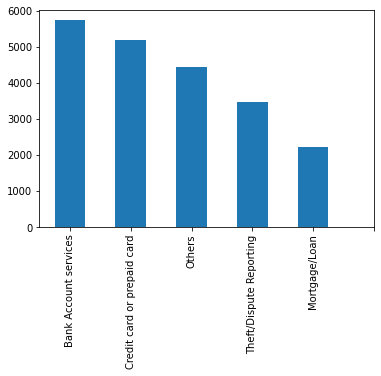

In [ ]:
training_data.Topic.value_counts().plot.bar()
plt.xticks([0, 1, 2,3,4,5], ["Bank Account services", "Credit card or prepaid card", "Others",'Theft/Dispute Reporting',
                             'Mortgage/Loan'])
plt.show()

Inference:

Simple inference is that there are more queries in the area of bank account services and credit card enquiries

####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [ ]:
#Write your code to get the Vector count

count_vect = CountVectorizer()
vect_counts = count_vect.fit_transform(training_data['pos_tagged_complaints'])

#Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()
vect_counts_tfidf = tfidf_transformer.fit_transform(vect_counts)


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics

##Importing again necessary modules

from nltk.corpus import stopwords
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

##Model import
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import warnings
warnings.filterwarnings("ignore")



In [ ]:
##Train-Test Split

X_train, X_test, y_train, y_test = train_test_split(vect_counts_tfidf, training_data.Topic, test_size=0.3, random_state=42)

# Printig the test-train data shape

print('The X_train data shape ',X_train.shape )
print('The y_train data shape ',y_train.shape )
print('The X_test data shape ',X_test.shape )
print('The y_test data shape ',y_test.shape )



The X_train data shape  (14750, 16759)
The y_train data shape  (14750,)
The X_test data shape  (6322, 16759)
The y_test data shape  (6322,)


We are now ready with the data and let us experiment with 4 models as mentioned. We need the model to make less false positive and false negative errors to be minimum, so we prefer the F1-score as the desired metric evaluation to accuracy. Since the class is slightly imbalanced, we use weighted F1-score

Defining the custom function which outputs the confusion matrix in DataFrame

1. For interactivity in a column maximum value is colored by red and minimum value is colored by light-green

In [ ]:
def model_confusion(y_test,y_pred,model):
  matrix_detail = confusion_matrix(y_test, y_pred)
  confusion_df=pd.DataFrame(matrix_detail)
  confusion_df=confusion_df.rename(columns={0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"},index={0:"Bank Account services",
               1:"Credit card or prepaid card", 
               2:"Others",
               3:"Theft/Dispute Reporting",
               4:"Mortgage/Loan"})
  print('Confusion matrix summary for ',model)
  return (confusion_df.style.highlight_max(color = 'red', axis = 0).highlight_min(axis=0, color='lightgreen'))

F1-Score of Logistic Model and confusion matrix

In [ ]:
#Defining the model and hyperparameter

#logistic = LogisticRegression()
#C = [0.001,0.01,0.1,1,10,100]
#penalty = ['l1', 'l2','Elastic-Net']

# create 5 folds

#folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# create gridsearch object
#model = GridSearchCV(estimator=logistic,
                     #cv=folds,
                     #param_grid=params,
                     #scoring='f1_weighted', 
                     #n_jobs=-1, 
                     #verbose=1)
# fit model
#model.fit(X_train, y_train)
#print("Best hyperparameters: ", model.best_params_)

Best Hyperparameter for the logistic model is as follows:

Logistic Regression : Best hyperparameters: {'logistic__C': 10, 'logistic__penalty': 'l2'}

Model training and predicting on test date

In [ ]:
logistic = LogisticRegression(C=10,penalty='l2')
logistic.fit(X_train, y_train)
y_pred1=logistic.predict(X_test)


Getting the weighted F1-Score on the test data set

In [ ]:
f1_lr = f1_score(y_test, y_pred1, average="weighted")
f1_lr

0.956182561584858

Getting the confusion matrix for logistic model in the dataframe

For interactivity in a column maximum value is colored by red and minimum value is colored by light-green

In [ ]:
model='Logistic Regression Model'
model_confusion(y_test,y_pred1,model)

Confusion matrix summary for  Logistic Regression Model


,Bank Account services,Credit card or prepaid card,Others,Theft/Dispute Reporting,Mortgage/Loan
Bank Account services,1679,27,14,27,9
Credit card or prepaid card,18,1512,14,23,14
Others,5,5,649,2,9
Theft/Dispute Reporting,37,23,3,1245,7
Mortgage/Loan,24,4,6,6,960


In [ ]:
results = pd.DataFrame({'Model':['Logistic Model'], 'Weighted-F1':[f1_lr]})
results = results[['Model', 'Weighted-F1']]
#results=pd.concat([results_1,results])
results

,Model,Weighted-F1
0,Logistic Model,0.956183


##Decision Tree modelling 

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
#dt = DecisionTreeClassifier(random_state=42)

# hyperparameter space

#params = {
    #'decision_tree__max_depth': [2, 3, 5, 10, 20],
    #'decision_tree__min_samples_leaf': [5, 10, 20, 50, 100],
    #'decision_tree__criterion': ["gini", "entropy"]
#}

# create 5 folds
#folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Instantiate the grid search model
#DT_Model = GridSearchCV(estimator=combined_pipeline, 
                         #cv=folds,
                          #param_grid=params, 
                          #n_jobs=-1, verbose=1, scoring = "f1_weighted")
# fit model
#DT_Model.fit(X_train, y_train)

#print("Best hyperparameters: ", DT_Model.best_params_)
#y_pred_dt = DT_Model.best_estimator_.predict(X_test)

The best hyperparameter selection for Decision tree is

Decision Tree: Best hyperparameters: {'decision_tree__criterion': 'gini', 'decision_tree__max_depth': 20, 'decision_tree__min_samples_leaf': 5}

##Building the Decision Tree with appropriate tuned hyperparameter

In [ ]:
dt = DecisionTreeClassifier(criterion='gini',max_depth=20,min_samples_leaf=5,random_state=42)


Training the model and predicting on the test data

In [ ]:
dt.fit(X_train, y_train)
y_pred_dt=dt.predict(X_test)

Calculating the weighted F1-Score for the DT model

In [ ]:
f1_dt = f1_score(y_test, y_pred_dt, average="weighted")
f1_dt

0.8356154286995262

Decision Tree confusion matrix and F1-Score dataframe

In [ ]:
model='Decision Tree Method'
model_confusion(y_test,y_pred_dt,model)

Confusion matrix summary for  Decision Tree Method


,Bank Account services,Credit card or prepaid card,Others,Theft/Dispute Reporting,Mortgage/Loan
Bank Account services,1468,65,29,115,79
Credit card or prepaid card,78,1372,28,73,30
Others,28,29,551,18,44
Theft/Dispute Reporting,108,98,18,1020,71
Mortgage/Loan,42,31,28,26,873


In [ ]:
results_1 = pd.DataFrame({'Model':['Decision Tree'], 'Weighted-F1':[f1_dt]})
results_1 = results_1[['Model', 'Weighted-F1']]
results=pd.concat([results_1,results])
results

,Model,Weighted-F1
0,Decision Tree,0.835615
0,Logistic Model,0.956183


##Hyperparameter tuning for Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#rf = RandomForestClassifier(random_state=42)

#Defining the chosen parameters which is used to run the hyperparameter
#params = {
    #rf__n_estimators': [100, 200, 300, 500, 800]
    #"rf__max_depth": [2,3,5,10,20],
    #"rf__min_samples_leaf": [5,10,20,50,100,500],
    #"rf__min_samples_split":[2,3,5,10,20],
    #'rf__criterion': ["gini", "entropy"],
#}

# create 5 folds
#folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Instantiate the grid search model
#RF_Model = GridSearchCV(estimator=combined_pipeline, 
                         #cv=folds,
                         #param_grid=params, 
                         #n_jobs=-1, verbose=1, scoring = "f1_weighted")
# fit model
#RF_Model.fit(X_train, y_train)

#print("Best hyperparameters: ", RF_Model.best_params_)

##Building the Random Forest Model with hyperparamters

In [ ]:
rf = RandomForestClassifier(criterion='gini',n_estimators=100,max_depth=20,min_samples_leaf=5,min_samples_split=2,random_state=42)

Model learning and testing on test data

In [ ]:
rf.fit(X_train, y_train)
y_pred_rf=rf.predict(X_test)

Getting the F1-Score and Confusion matrix

In [ ]:
f1_rf = f1_score(y_test, y_pred_rf, average="weighted")
f1_rf

0.7498522395231391

In [ ]:
#Getting the confusion matrix
model='Random Forest'
model_confusion(y_test,y_pred_rf,model)

Confusion matrix summary for  Random Forest


,Bank Account services,Credit card or prepaid card,Others,Theft/Dispute Reporting,Mortgage/Loan
Bank Account services,1639,82,0,23,12
Credit card or prepaid card,87,1410,0,71,13
Others,163,198,125,68,116
Theft/Dispute Reporting,260,137,0,904,14
Mortgage/Loan,99,86,3,7,805


In [ ]:
##Getting the F1-score in dataframe
results_2 = pd.DataFrame({'Model':['Random Forest'], 'Weighted-F1':[f1_rf]})
results_2 = results_2[['Model', 'Weighted-F1']]
results=pd.concat([results_2,results])
results

,Model,Weighted-F1
0,Random Forest,0.749852
0,Decision Tree,0.835615
0,Logistic Model,0.956183


#Experimenting with Naive Bayes model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
#nb =MultinomialNB()

#Defining the chosen parameters which is used to run the hyperparameter
#params = {'nb__alpha': np.logspace(0,-15, num=120)}

# create 5 folds
#folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

# Instantiate the grid search model
#NB_Model = GridSearchCV(estimator=combined_pipeline, 
                         #cv=folds,
                         #param_grid=params, 
                         #n_jobs=-1, verbose=1, scoring = "f1_weighted")
# fit model
#NB_Model.fit(X_train, y_train)

#print("Best hyperparameters: ", NB_Model.best_params_)


Modelling the Naive Bayes using the tuned parameters

In [ ]:
nb =MultinomialNB(alpha=0.0733746797065138)

Predicting on Test data

In [ ]:
nb.fit(X_train, y_train)
y_pred_nb=nb.predict(X_test)

Getting the F1-Score and putting it in a dataframe

In [ ]:
f1_nb = f1_score(y_test, y_pred_nb, average="weighted")
f1_nb

0.7837758567661494

In [ ]:
##Getting the F1-score in dataframe
results_3 = pd.DataFrame({'Model':['Naive Bayes'], 'Weighted-F1':[f1_nb]})
results_3 = results_3[['Model', 'Weighted-F1']]
results=pd.concat([results_3,results])
results

,Model,Weighted-F1
0,Naive Bayes,0.783776
0,Random Forest,0.749852
0,Decision Tree,0.835615
0,Logistic Model,0.956183


Getting the confusion matrix for NB prediction

In [ ]:
#Getting the confusion matrix
model='Naive Bayes'
model_confusion(y_test,y_pred_nb,model)

Confusion matrix summary for  Naive Bayes


,Bank Account services,Credit card or prepaid card,Others,Theft/Dispute Reporting,Mortgage/Loan
Bank Account services,1496,123,13,78,46
Credit card or prepaid card,107,1269,26,148,31
Others,82,108,337,49,94
Theft/Dispute Reporting,183,87,18,1011,16
Mortgage/Loan,44,52,30,7,867


From all the models, logistic outperforms others in terms of our chosen metric

##Predicting in real-life

Let us use our own complaints to inspect how our model is able to categorize the complaints based on the description we feed in

In [ ]:
##Creating a simple function for prediction

def predict_topic(news):
    vect_counts_new = count_vect.transform(news)
    vect_counts_tfidf = tfidf_transformer.transform(vect_counts_new)
    prediction= logistic.predict(vect_counts_tfidf)
    return prediction[0]


In [ ]:
df_complaints = pd.DataFrame({'complaints': ["I applied for my credit card and my application is still on hold and has been a week, this is frustrating", 
                                  "May I know the procedure to apply for the education loan at least interest",
                                  "I want to tranfer my bank account to another branch of yours please share me the steps so that I can do it in online",
                                  "Yesterday I received a fraud message using the company domain",
                                  "My EMI is getting debited eventhough I refrain from the scheme do check it out",
                                  "How many ATM services are there currently operable in Chennai, many of the ATM centers of your branch is in pathetic condition, do check it out"]})
df_complaints

,complaints
0,"I applied for my credit card and my application is still on hold and has been a week, this is frustrating"
1,May I know the procedure to apply for the education loan at least interest
2,I want to tranfer my bank account to another branch of yours please share me the steps so that I can do it in online
3,Yesterday I received a fraud message using the company domain
4,My EMI is getting debited eventhough I refrain from the scheme do check it out
5,"How many ATM services are there currently operable in Chennai, many of the ATM centers of your branch is in pathetic condition, do check it out"


Mapping the numbers to the desired complaint category

In [ ]:
topic_name={0:"Bank Account services",1:'Credit card or prepaid card',
                            2:'Others',3:'Theft/Dispute Reporting',4:'Mortgage/Loan'}

In [ ]:
df_complaints['predicted topic'] = df_complaints['complaints'].apply(lambda x: predict_topic([x]))
df_complaints['predicted topic']=df_complaints['predicted topic'].map(topic_name)
df_complaints

,complaints,predicted topic
0,"I applied for my credit card and my application is still on hold and has been a week, this is frustrating",Credit card or prepaid card
1,May I know the procedure to apply for the education loan at least interest,Mortgage/Loan
2,I want to tranfer my bank account to another branch of yours please share me the steps so that I can do it in online,Bank Account services
3,Yesterday I received a fraud message using the company domain,Theft/Dispute Reporting
4,My EMI is getting debited eventhough I refrain from the scheme do check it out,Bank Account services
5,"How many ATM services are there currently operable in Chennai, many of the ATM centers of your branch is in pathetic condition, do check it out",Bank Account services
